# This notebook checks the results after a simulation

## init stuff

In [499]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [500]:
import sys
sys.path.append('..')

In [501]:
import os
import glob
from result_utils.results_utils import xml2csv_path
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from result_utils.dotdict import dotdict
from matplotlib.collections import LineCollection 

In [502]:
import sumolib

In [503]:
def flatten(l):
    return [item for sublist in l for item in sublist]

def plotNet(net, colors, widths, options, incident_edge_obj, ax, margin=1600, area=None):
    shapes = []
    c = []
    w = []
    for e in net._edges:
        shapes.append(e.getShape())
        if e._id in colors:
            c.append(colors[str(e._id)])
        else:
            c.append(options.defaultColor)
        if e._id in widths:
            w.append(widths[str(e._id)])
        else:
            w.append(options.defaultWidth)

    line_segments = LineCollection(shapes, linewidths=w, colors=c)
    ax = plt.gca()
    ax.add_collection(line_segments)
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    
    (xmin, ymin, xmax, ymax) = incident_edge_obj.getBoundingBox()
    if area is not None:
        ax.set_xlim(area['xmin'] ,area['xmax'])
        ax.set_ylim(area['ymin'] ,area['ymax'])
    else:
        ax.set_xlim(xmin - margin ,xmax + margin)
        ax.set_ylim(ymin - margin ,ymax + margin)
    
    #ax.autoscale_view(True, True, True)
    return ax


In [504]:
scenario = 'motorway'
path = f'../{scenario}/Results'


In [505]:
result_folders = os.listdir(path)
#result_folders

In [321]:
experiment_name = 'test_run_two'
experiment_folders = [folder for folder in result_folders if folder.startswith(experiment_name)]

In [322]:
print(f'{len(experiment_folders)} experiments')

60 experiments


In [323]:
for folder in experiment_folders:
    result_xmls = [xml for xml in glob.glob(f'{path}/{folder}/*.xml') if 'log' not in xml]
    if len(glob.glob(f'{path}/{folder}/*.csv')) < len(result_xmls):
        print(f'Found fewer csv files than xml files in {folder}. Converting results')
        xml2csv_path(f'{path}/{folder}')
        print(f'finished converting {folder}')
    #else: print(f"All files in {folder} seems converted.")

# Load incident and net

In [324]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)

In [325]:
# one 3, 9
# two 3
experiment = experiment_folders[4]
experiment_path = f'{path}/{experiment}'

print(experiment_path)
#os.listdir(experiment_path)

with open(f'{experiment_path}/incident_settings.json') as f:
    incident_settings = json.load(f)
print(incident_settings)

incident_edge = incident_settings['edge']
i_edge_obj = net.getEdge(incident_edge)

hours = incident_settings['start_time'] // 60 // 60
minutes = incident_settings['start_time'] // 60 % 60
seconds = incident_settings['start_time'] % 60
print(f'Incident at {hours}:{minutes}:{seconds}')

../motorway/Results/test_run_two_53
{'slow_zone': 70, 'lc_zone': 20, 'lc_prob_zone': 170, 'slow_zone_speed': 5, 'run_num': 53, 'is_incident': True, 'is_random': True, 'random_seed': 231602494, 'edge': '4414080#0.756.47', 'lanes': [0, 1, 2], 'pos': 21.82098870155751, 'start_time': 36785, 'start_step': 73570, 'duration_time': 1163, 'duration_steps': 2326}
Incident at 10:13:5


In [416]:
n_up = 3
n_down = 3


upstream_edges = {}
upstream_edges[0] = list(i_edge_obj.getIncoming().keys())

for i in range(0, n_up):
    next_edges = []
    for edge in upstream_edges[i]:
        next_edges += (list(edge.getIncoming().keys()))
    upstream_edges[i+1] = next_edges
    
upstream_edges_ids = {}
for i in range(0, n_up + 1):
    level_ids = []
    for edge in upstream_edges[i]:
        level_ids += [edge.getID()]
    upstream_edges_ids[i] = level_ids
    
all_upstream_edges_ids = flatten(list(upstream_edges_ids.values()))

downstream_edges = {}
downstream_edges[0] = list(i_edge_obj.getOutgoing().keys())

for i in range(0, n_down):
    next_edges = []
    for edge in downstream_edges[i]:
        next_edges += (list(edge.getOutgoing().keys()))
    downstream_edges[i+1] = next_edges
    
downstream_edges_ids = {}
for i in range(0, n_down + 1):
    level_ids = []
    for edge in downstream_edges[i]:
        level_ids += [edge.getID()]
    downstream_edges_ids[i] = level_ids
    
all_downstream_edges_ids = flatten(list(downstream_edges_ids.values()))

edge_to_level_dict = {}
for level in upstream_edges_ids.keys():
    for i, edge in enumerate(upstream_edges_ids[level]):
        edge_to_level_dict[edge] = f'upstream_{level}_{i}'

for level in downstream_edges_ids.keys():
    for i, edge in enumerate(downstream_edges_ids[level]):
        edge_to_level_dict[edge] = f'downstream_{level}_{i}'

edge_to_level_dict[incident_edge] = 'incident_edge'
        
#edge_to_level_dict
    

# Map

<AxesSubplot:>

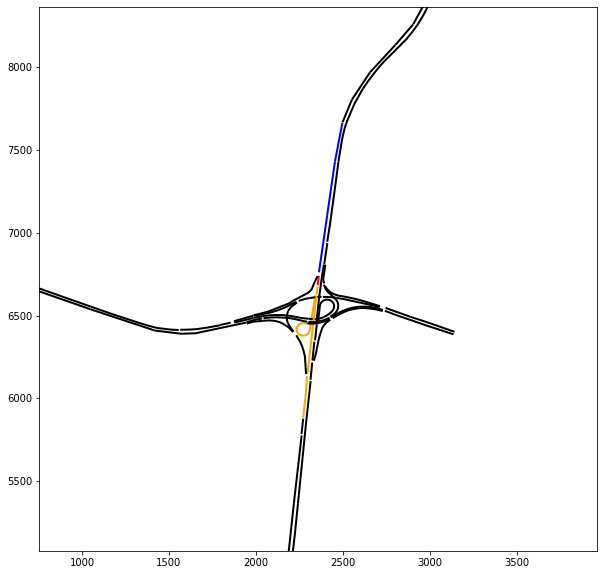

In [518]:
#net_path = '../experiment/Simulations/Base/traci_exp.net.xml'
net_path = '../motorway/Simulations/Base/network.net.xml'
net = sumolib.net.readNet(net_path)
plot_options = {'defaultColor': 'black',
                'defaultWidth': 2}
plot_options = dotdict(plot_options)
edge_colors = {incident_edge: 'red'}

for i in range(n_up):
    for id in upstream_edges_ids[i]:
        edge_colors[id] = 'orange'
        
for i in range(n_down):
    for id in downstream_edges_ids[i]:
        edge_colors[id] = 'blue'
        
fig, ax = plt.subplots(1, figsize=(10,10))
plotNet(net, edge_colors, {}, plot_options, i_edge_obj, ax)


## check counterfactuals

In [519]:
results_incident = pd.read_csv(f'{experiment_path}/edgedata.csv', sep=';')
results_incident = results_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
results_incident_table = results_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

counterfactual_incident = pd.read_csv(f'{experiment_path}/edgedata_counterfactual.csv', sep=';')
counterfactual_incident = counterfactual_incident[['edge_id', 'interval_begin', 'edge_density', 'edge_occupancy', 'edge_speed', 'edge_waitingTime', 'edge_timeLoss']]
counterfactual_incident_table = counterfactual_incident.pivot(index='edge_id', columns='interval_begin', values=['edge_speed','edge_density'])

relevant_edges = all_upstream_edges_ids + all_downstream_edges_ids + [incident_edge]
upstream_edges = all_upstream_edges_ids + [incident_edge]
downstream_edges = all_downstream_edges_ids + [incident_edge]

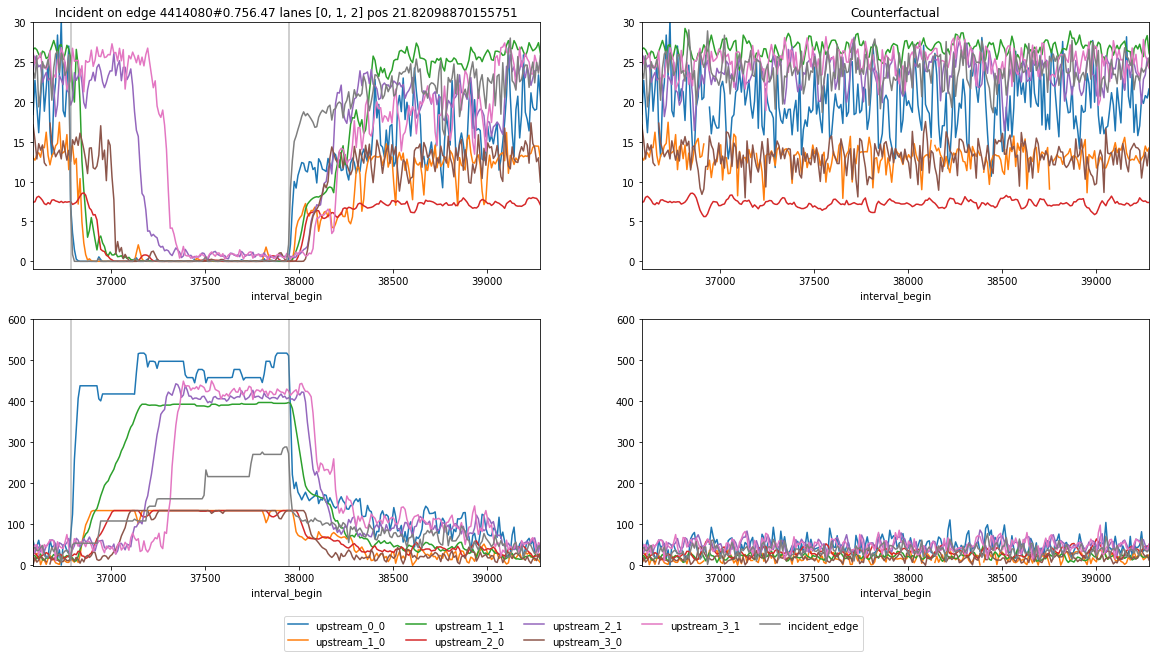

In [520]:
chosen_edges = upstream_edges


fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 600)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

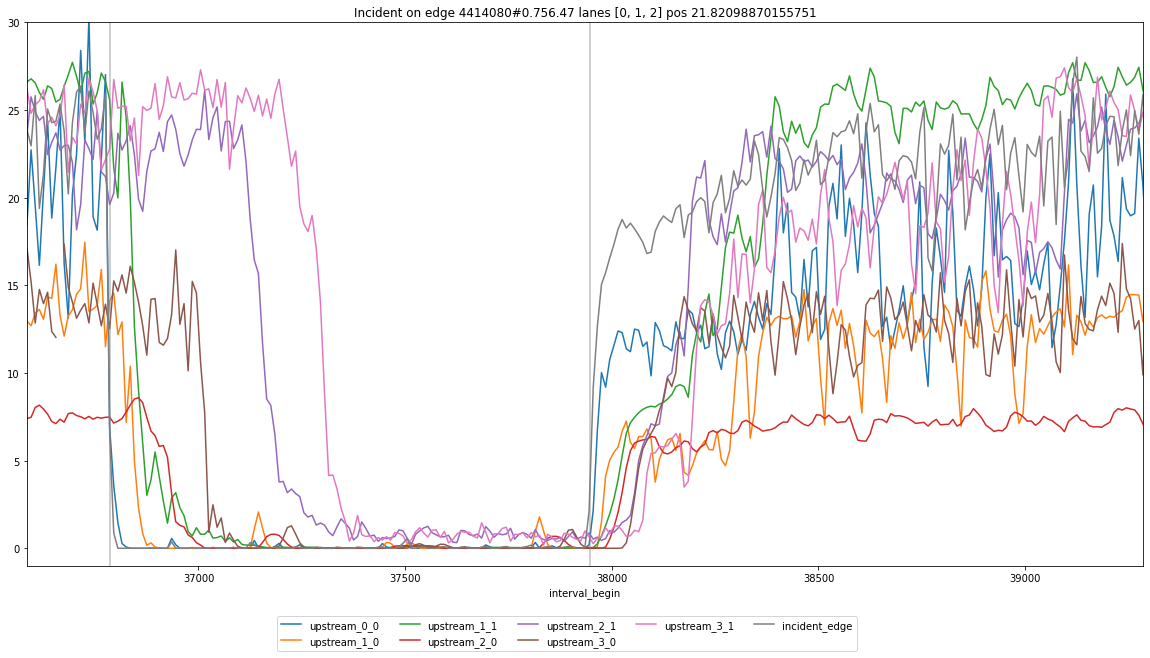

In [521]:
chosen_edges = upstream_edges


fig, ax = plt.subplots(1,1)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax, legend=False)
ax.set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')

ax.set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax.set_ylim(-1, 30)


ax.axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax.axvline(incident_settings['start_time'] + incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
plt.savefig('fig1.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [447]:
os.listdir('.')

['check_results_base1.ipynb',
 'incident_settings.json',
 'check_results_counterfactual_exp1.ipynb',
 '.ipynb_checkpoints',
 'fig1.png',
 'Untitled.ipynb']

In [448]:
edge_colors_2 = {}
for handle in handles:
        edge_colors_2[handle.get_label()] = handle.get_color()

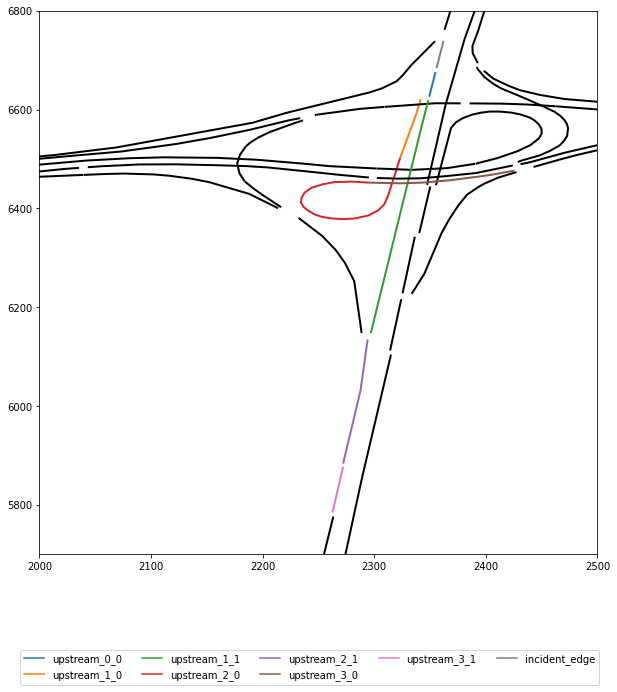

In [451]:
# 3 area = {'xmin':500 , 'xmax':3000 ,'ymin':4000 ,'ymax':8000 }
area = {'xmin':2000 , 'xmax':2500 ,'ymin':5700 ,'ymax':6800 }
fig, ax = plt.subplots(1, figsize=(10,10))
plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, area=area)
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)
#plotNet(net, edge_colors_2, {}, plot_options, i_edge_obj, ax, margin=1000)

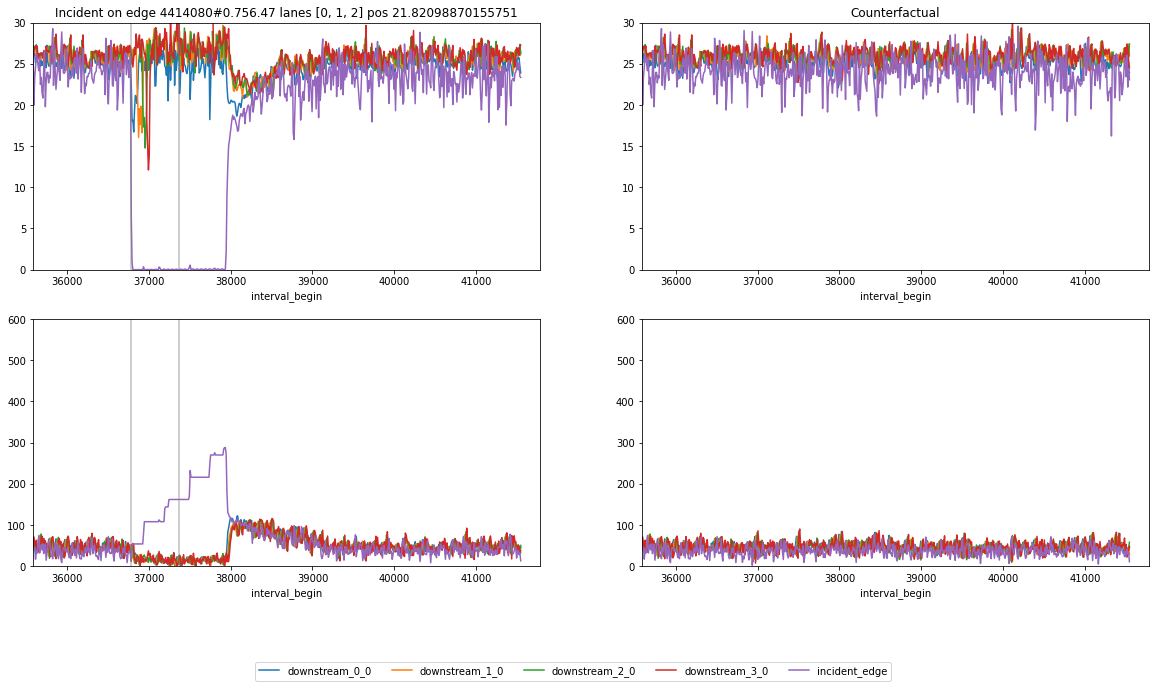

In [452]:
chosen_edges = downstream_edges


fig, ax = plt.subplots(2,2)

results_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,0], legend=False)
ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
results_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_incident_table.loc[chosen_edges].edge_speed.T.plot(figsize=(20,10), ax=ax[0,1], legend=False)
ax[0,1].set_title(f'Counterfactual')
counterfactual_incident_table.loc[chosen_edges].edge_density.T.plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 600)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 600)


ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare edge with detector data

In [507]:
results_detector = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
#results_detector = results_detector.replace(-1,np.nan)
results_detector_table = results_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_speed'])
#results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T

In [513]:
results_detector = pd.read_csv(f'{experiment_path}/detectordata.csv', sep=';')
results_detector = results_detector.replace(-1,np.nan)
results_detector_table = results_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_nVehEntered',
                                                                                                       'interval_occupancy',
                                                                                                       'interval_speed'])
results_detector_table = results_detector_table.groupby(results_detector_table.index.str.split('_').str[1]).mean().T



counterfactual_detector = pd.read_csv(f'{experiment_path}/detectordata_counterfactual.csv', sep=';')
counterfactual_detector = counterfactual_detector.replace(-1,np.nan)
counterfactual_detector_table = counterfactual_detector.pivot(index='interval_id', columns='interval_begin', values=['interval_flow',
                                                                                                       'interval_harmonicMeanSpeed',
                                                                                                       'interval_nVehContrib',
                                                                                                       'interval_nVehEntered',
                                                                                                       'interval_occupancy',
                                                                                                       'interval_speed'])
counterfactual_detector_table = counterfactual_detector_table.groupby(counterfactual_detector_table.index.str.split('_').str[1]).mean().T

<AxesSubplot:xlabel='interval_begin'>

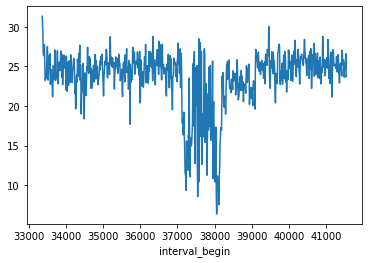

In [514]:
results_detector_table['4414080#0'].loc['interval_speed'].dropna().plot()

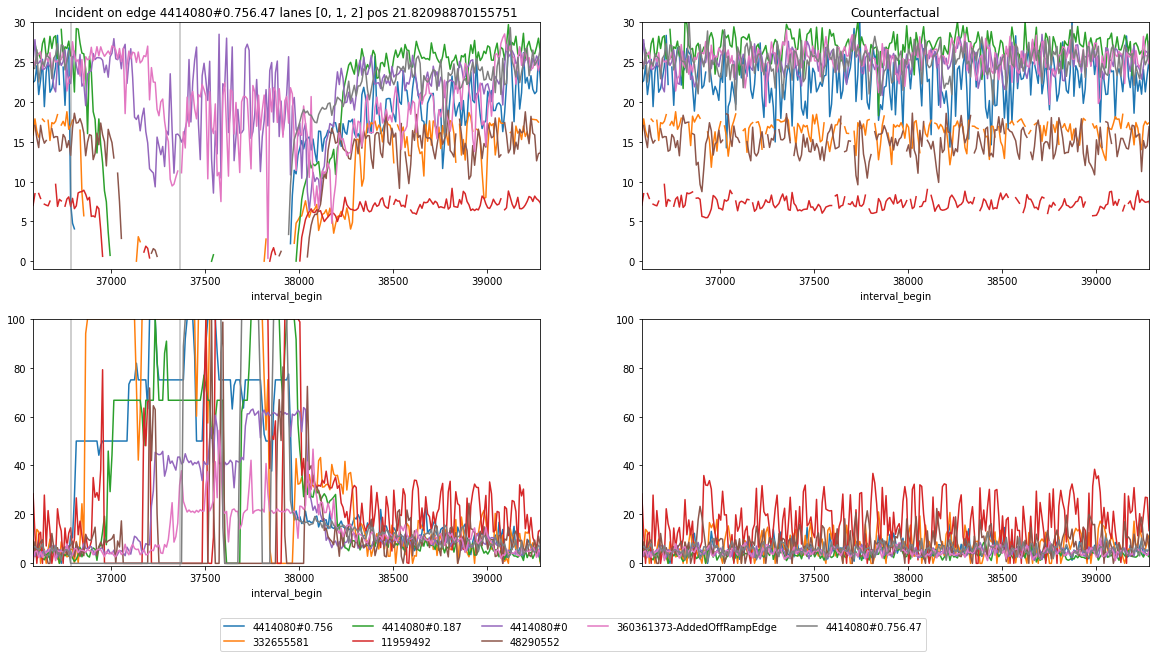

In [515]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')
ax[0,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
#lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

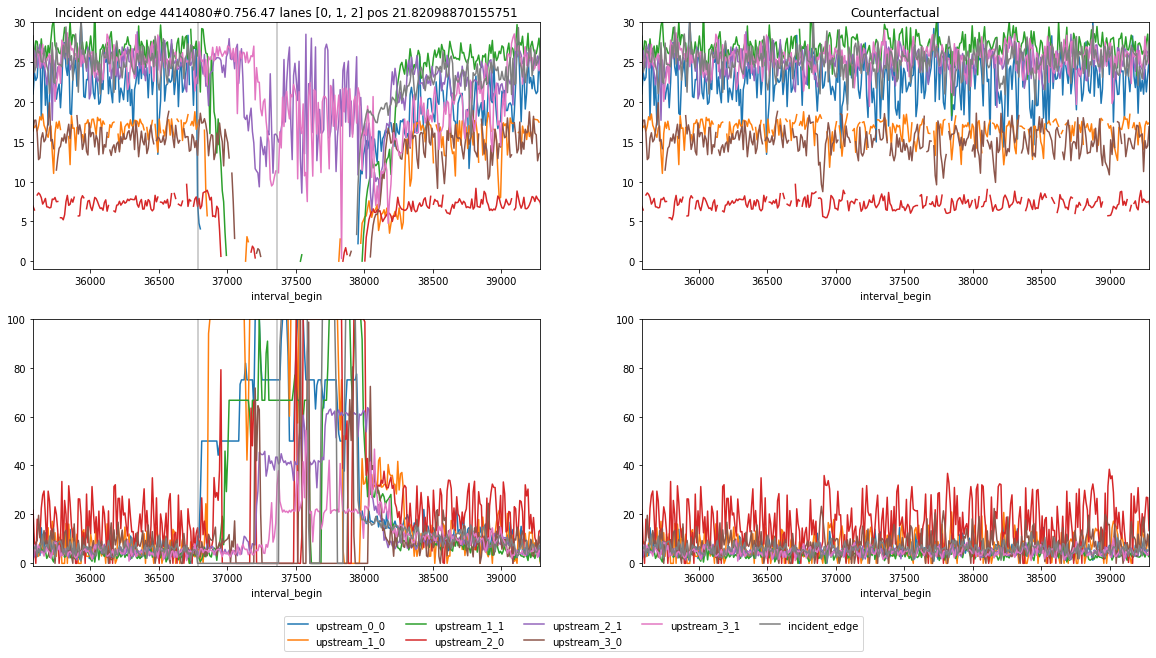

In [516]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 2500)
ax[0,0].set_ylim(-1, 30)
ax[1,0].set_ylim(-1, 100)
ax[0,1].set_ylim(-1, 30)
ax[1,1].set_ylim(-1, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
lgd = fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=5)

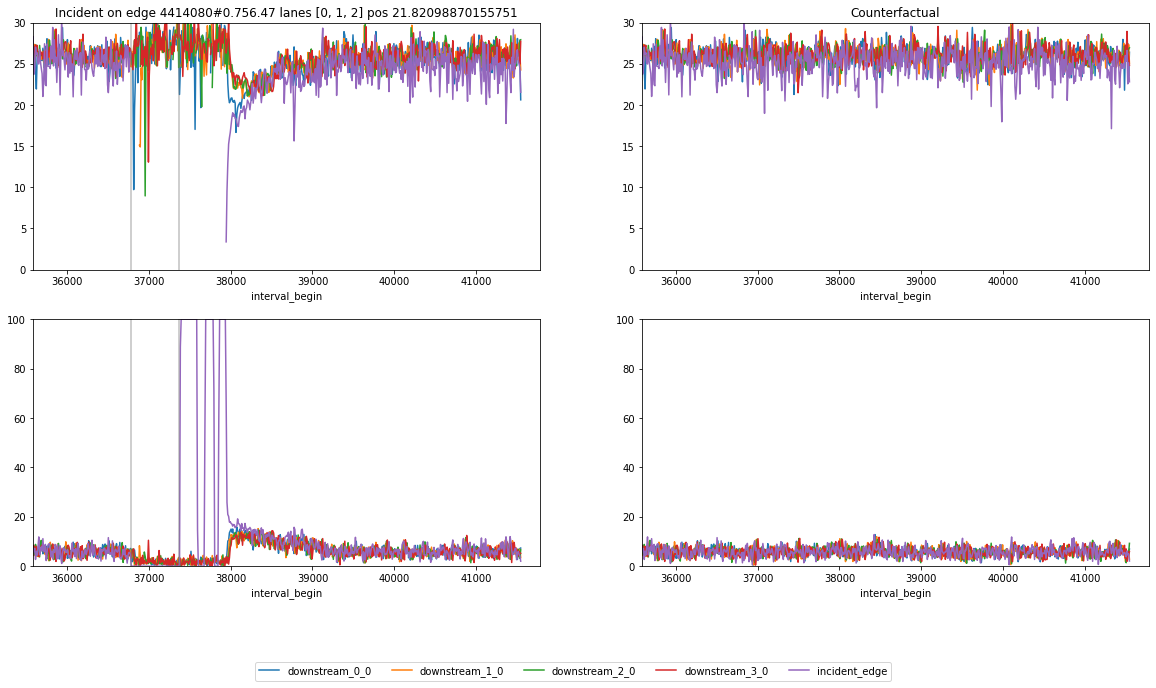

In [517]:
chosen_edges = downstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,0], legend=False)
results_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,0], legend=False)

counterfactual_detector_table[chosen_edges].loc['interval_speed'].plot(figsize=(20,10), ax=ax[0,1], legend=False)
counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].plot(figsize=(20,10), ax=ax[1,1], legend=False)

ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')
ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)
ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

In [352]:
# Do the mean thing

In [353]:
results_detector_table.loc['interval_speed']

interval_id,106130759,106130759-AddedOffRampEdge,106130759.1186,106130759.1630,106130759.1868,106130759.2098,106130759.2437,106130759.791,11955830,11955831,...,75266094,gneE0,gneE10,gneE11,gneE12,gneE2,gneE3,gneE4,gneE6,gneE7
interval_begin,,,,,,,,,,,,,,,,,,,,,
33185.0,13.8575,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000000,0.0000,...,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33195.0,20.6600,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,26.4750,0.000000,0.0000,...,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33205.0,26.8175,0.000,21.4475,0.0000,0.0000,0.0000,0.0000,22.2300,0.000000,0.0000,...,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33215.0,30.0100,0.000,25.0050,7.4850,0.0000,0.0000,0.0000,25.9350,0.000000,0.0000,...,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
33225.0,29.0975,0.000,28.7325,21.0875,14.0625,0.0000,0.0000,24.9525,0.000000,0.0000,...,0.000,0.000000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41505.0,27.8650,13.330,26.0550,25.6975,19.5175,20.9250,20.6725,26.4850,15.160000,12.5400,...,8.270,4.210000,25.3900,24.7700,27.3650,26.3550,26.3325,26.2575,24.8400,24.7875
41515.0,13.3850,16.810,27.1775,25.5950,26.0300,21.9350,20.2025,25.2425,11.340000,12.5025,...,7.035,11.776667,24.5550,25.5675,24.9550,26.6400,26.4275,26.1875,26.3625,24.9700
41525.0,28.2425,17.210,25.7700,27.2575,25.5300,16.5250,18.0850,25.6000,16.593333,7.9150,...,16.915,12.953333,24.7025,23.9250,25.5000,26.3950,26.6350,26.6450,26.2775,25.9100


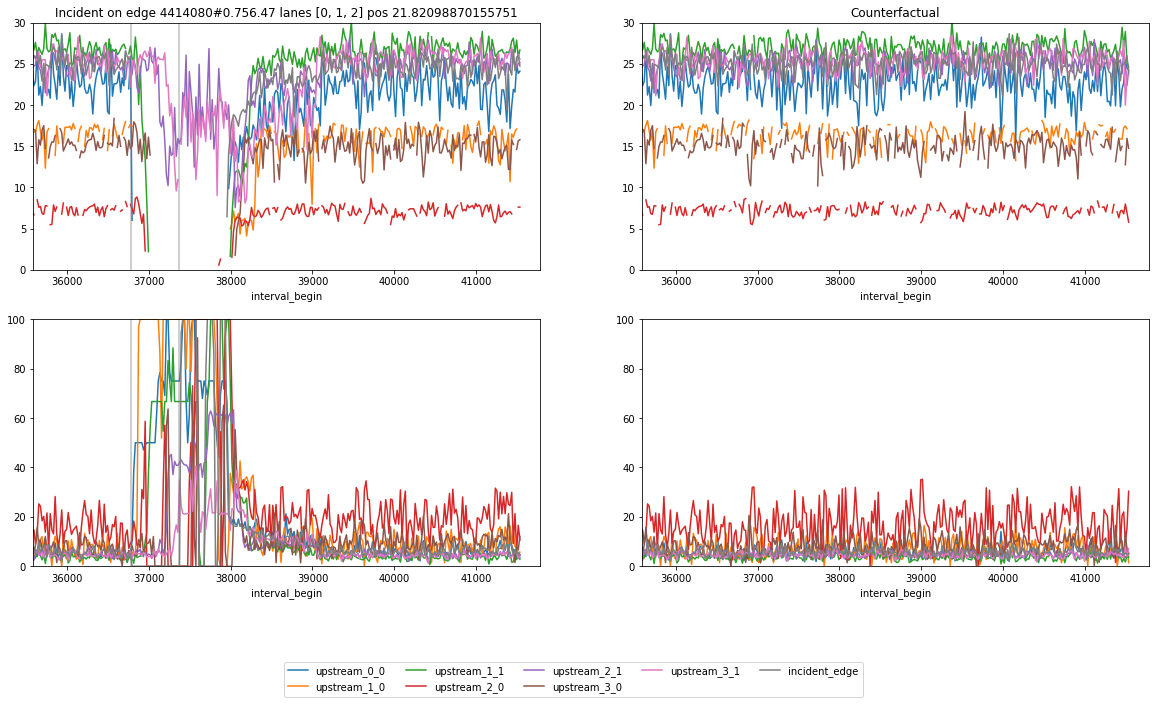

In [382]:
chosen_edges = upstream_edges

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(2).mean().iloc[1::2].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

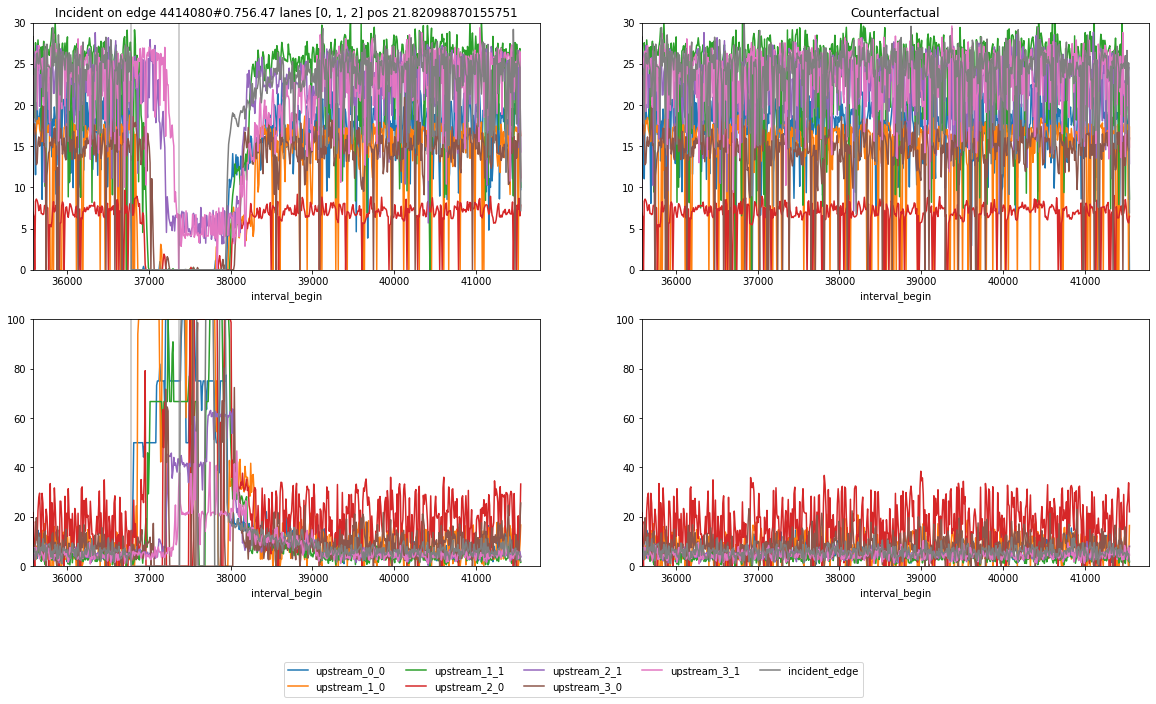

In [370]:
chosen_edges = upstream_edges
n_mean = 1

fig, ax = plt.subplots(2,2)

results_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,0], legend=False)



results_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,0], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_speed'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[0,1], legend=False)



counterfactual_detector_table[chosen_edges].loc['interval_occupancy'].rolling(n_mean).mean().iloc[1::n_mean].plot(figsize=(20,10), ax=ax[1,1], legend=False)






ax[0,0].set_title(f'Incident on edge {incident_settings["edge"]} lanes {incident_settings["lanes"]} pos {incident_settings["pos"]}')
ax[0,1].set_title(f'Counterfactual')

ax[0,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,0].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[1,1].set_xlim(incident_settings['start_time'] - 1200 ,incident_settings['start_time'] + 5000)
ax[0,0].set_ylim(0, 30)
ax[1,0].set_ylim(0, 100)
ax[0,1].set_ylim(0, 30)
ax[1,1].set_ylim(0, 100)

ax[0,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'], color='grey', alpha=0.5)
ax[0,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)
ax[1,0].axvline(incident_settings['start_time'] + 0.5 * incident_settings['duration_time'], color='grey', alpha=0.5)

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, [edge_to_level_dict[label] for label in labels], loc='upper center', bbox_to_anchor=(0.5, -0.001), ncol=5)

## Compare incident with counterfactual

- Can we see all of the impacted edges?


In [ ]:
# Seems like I can remove the smalles of them here to find the backlog


In [520]:
residuals = (results_detector_table.interval_speed - counterfactual_detector_table.interval_speed).T.abs().max()

<AxesSubplot:xlabel='interval_id'>

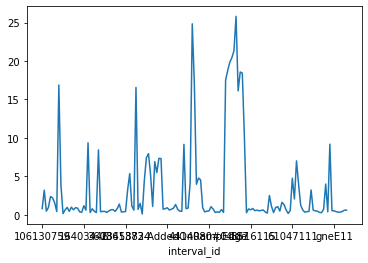

In [521]:
residuals.plot()

In [522]:
results_detector_table.loc[residuals > 5]

interval_flow                                  \
interval_begin                    46547.0 46847.0 47147.0 47447.0 47747.0   
interval_id                                                                 
11955830                            108.0   748.0   820.0   780.0   816.0   
17516648                            420.0   792.0   642.0   630.0   732.0   
208416643                           174.0   264.0   222.0   192.0   264.0   
28458895                            372.0   843.0   960.0   966.0  1005.0   
29038677                             84.0   540.0   636.0   612.0   612.0   
328393125                           225.0   804.0   912.0   894.0   945.0   
328393125-AddedOnRampEdge           192.0   650.4   727.2   712.8   770.4   
332655578                           360.0   750.0   666.0   648.0   678.0   
345616204#1                         312.0   966.0  1107.0  1113.0  1155.0   
345616204#1-AddedOnRampEdge         271.2   768.0   902.4   868.8   928.8   
345616204#1.334                     282.0   933.0  1128.0  1125.0  1137.0   
345616204#1.655                     273.0   906.0  1107.0  1116.0  1158.0   
41517592                            450.0   702.0   624.0   684.0   732.0   
429432524                           152.0   732.0   828.0   772.0   820.0   
429432526                            78.0   816.0   876.0   876.0   966.0   
48290550                            609.0  1191.0  1161.0  1176.0  1188.0   
48290550-AddedOffRampEdge           142.0   728.0   784.0   772.0   778.0   
48290550.1176                       477.0  1179.0  1161.0  1170.0  1182.0   
48290550.1480                       420.0  1185.0  1149.0  1185.0  1167.0   
48290550.1878                       402.0  1140.0  1149.0  1167.0  1152.0   
48290550.2391                       330.0  1122.0  1110.0  1209.0  1182.0   
48290550.2904                       285.0  1095.0  1140.0  1173.0  1176.0   
48290550.3266                       187.2   873.6   940.8   924.0   933.6   
48290550.745                        540.0  1167.0  1173.0  1146.0  1200.0   
48290551#0                          276.0   360.0   378.0   336.0   384.0   
61047111.165                        544.8   945.6   928.8   955.2   912.0   
gneE0                                44.0   720.0   740.0   776.0   764.0   

                                                                     ...  \
interval_begin              48047.0 48347.0 48647.0 48947.0 49247.0  ...   
interval_id                                                          ...   
11955830                      816.0   872.0   752.0   888.0   768.0  ...   
17516648                      678.0   672.0   672.0   684.0   648.0  ...   
208416643                     192.0   204.0   180.0   222.0   156.0  ...   
28458895                     1014.0  1023.0   957.0  1014.0   975.0  ...   
29038677                      756.0   660.0   576.0   684.0   708.0  ...   
328393125                     930.0   966.0   969.0   846.0   984.0  ...   
328393125-AddedOnRampEdge     744.0   775.2   765.6   674.4   787.2  ...   
332655578                     720.0   660.0   690.0   666.0   654.0  ...   
345616204#1                  1140.0  1155.0  1209.0  1044.0  1158.0  ...   
345616204#1-AddedOnRampEdge   909.6   928.8   979.2   837.6   931.2  ...   
345616204#1.334              1128.0  1179.0  1176.0  1065.0  1158.0  ...   
345616204#1.655              1098.0  1182.0  1209.0  1062.0  1146.0  ...   
41517592                      720.0   684.0   756.0   660.0   738.0  ...   
429432524                     820.0   852.0   768.0   896.0   764.0  ...   
429432526                     804.0   954.0   858.0   972.0   804.0  ...   
48290550                     1257.0  1182.0  1191.0  1158.0  1227.0  ...   
48290550-AddedOffRampEdge     808.0   840.0   762.0   810.0   776.0  ...   
48290550.1176                1254.0  1188.0  1191.0  1173.0  1221.0  ...   
48290550.1480                1245.0  1218.0  1164.0  1173.0  1218.0  ...   
48290550.1878                1269.0  1218.0  

<AxesSubplot:xlabel='interval_begin'>

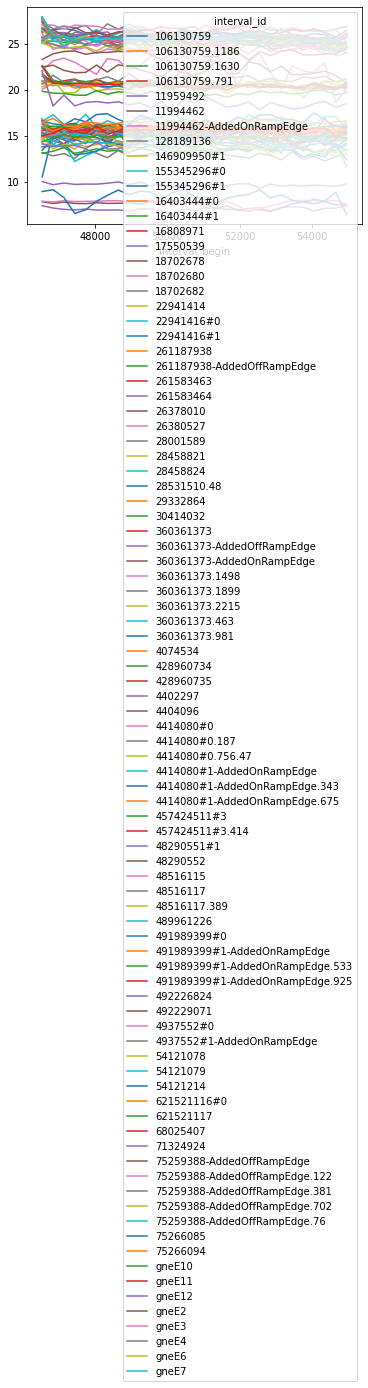

In [523]:
results_detector_table.loc[residuals < 1].interval_speed.T.plot()

In [496]:
residuals > 1

interval_id
106130759                     False
106130759-AddedOffRampEdge     True
106130759.1186                False
106130759.1630                False
106130759.1868                 True
                              ...  
gneE2                         False
gneE3                         False
gneE4                         False
gneE6                         False
gneE7                         False
Length: 147, dtype: bool

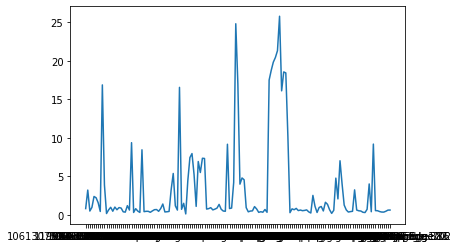

In [534]:
plt.plot(residuals)

In [531]:
with open('incident_settings.json', 'r') as f:
    test = json.load(f)

In [532]:
test

[{'run_num': 56,
  'is_incident': True,
  'is_random': True,
  'random_seed': 866779109,
  'edge': '208416643',
  'lanes': [0],
  'pos': 8.349012655541417,
  'start_time': 44356,
  'start_step': 88712,
  'duration_time': 1316,
  'duration_steps': 2632},
 {'run_num': 57,
  'is_incident': True,
  'is_random': True,
  'random_seed': 866779109,
  'edge': '208416643',
  'lanes': [0],
  'pos': 8.349012655541417,
  'start_time': 44356,
  'start_step': 88712,
  'duration_time': 1316,
  'duration_steps': 2632}]

# Create dataset from simulation

## How to create sequences from simulation

- Do we even do sequence to sequence?
- Do we make multiple sequences from each simulation or is each simulation separate?
- Should the incident happen the same time along the sequence for all of the simulations?
- Should sequences be the same length?
    - If we do backlog then no they should vary in length
    
## Create backlog from comparing incident with counterfactual

- Should it even be created looking at the counterfactual?
- How big a difference is necessary?
    -- Could be based on the LoS from the highway manual
- If this is model output how do we get a model to output it?
    - Some sequence model with a way to determine how to stop
        - This sounds like some NLP like problem